In [1]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split

# Model
from keras.applications import ResNet50V2, ResNet152V2


# Model training
from keras import Sequential
from keras import Model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import Input, InputLayer
from keras.layers import Lambda
from keras.layers import BatchNormalization
from keras.optimizers import Adam

# Model Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard


C:\Users\Home\miniconda3\envs\tf-2.10-gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPUs available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 전처리 파트 (수정 가능)

In [4]:
# import kagglehub
# 
# # Download latest version
# path = kagglehub.dataset_download("jangedoo/utkface-new")
# 
# print("Path to dataset files:", path)

In [3]:
# Setting constants for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224

# data path
IMAGE_PATH = "UTKFace"

# 데이터셋 점검 (수정 가능)

Total number of images  : 23707
Sample Image path       : 9_0_0_20170120133317677.jpg.chip.jpg
Sample Age              : 9
Sample Gender           : Male



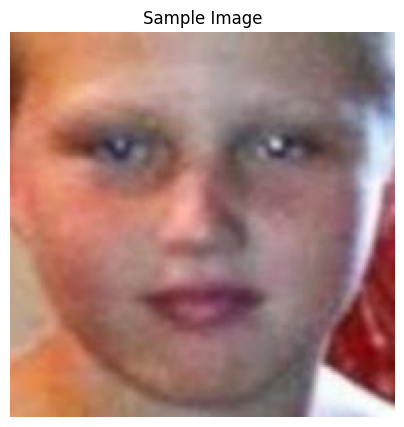

In [4]:
# Initialize the directory path
dir_path = IMAGE_PATH
image_paths = os.listdir(dir_path)

# Initialize a Gender Mapping
gender_mapping = ["Male", "Female"]

# Choose and load an image randomly
rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(os.path.join(dir_path, rand_image_path)) / 255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_paths)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")
print(f"Sample Gender           : {gender_mapping[int(sample_gender)]}\n")

# Show the image
plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

# 전처리 과정(파일 이름에서 라벨링, 수정 가능)

# 데이터셋 분할 (수정 가능)

In [5]:
# 이미지 경로들을 무작위로 섞기 (재현 가능성 위해 시드 고정)
np.random.seed(42)
np.random.shuffle(image_paths)

# 1. 전체 데이터 → 학습/테스트 분할 (90% 학습용, 10% 테스트용)
train_valid_images, test_images = train_test_split(
    image_paths,
    train_size=0.9,
    test_size=0.1,
    random_state=42
)

# 2. 학습용 데이터 → 학습/검증 분할 (90% 학습용, 10% 검증용)
train_images, valid_images = train_test_split(
    train_valid_images,
    train_size=0.9,
    test_size=0.1,
    random_state=42
)

# 결과 확인
print(f"Training Size  : {len(train_images)}")
print(f"Validation Size: {len(valid_images)}")
print(f"Testing Size   : {len(test_images)}")

# 나이 및 성별 라벨 추출 함수
def extract_labels(image_list):
    ages = [int(path.split("_")[0]) for path in image_list]
    return ages

# 학습, 검증, 테스트 데이터에 대해 라벨 추출
train_ages = extract_labels(train_images)
valid_ages = extract_labels(valid_images)
test_ages = extract_labels(test_images)

Training Size  : 19202
Validation Size: 2134
Testing Size   : 2371


# 전처리 과정 (이미지를 텐서 형태로 변환)

In [6]:
def show_image(image, show=False):
    """
    이미지를 시각화하는 함수입니다. 축은 제거되고,
    show=True일 경우에만 실제로 plt.show()로 출력합니다.

    Args:
    - image (array-like): 표시할 이미지 배열
    - show (bool): True이면 이미지 출력 (기본값: False)

    Returns:
    - None
    """
    plt.imshow(image)       # 이미지 시각화
    plt.axis("off")         # x, y 축 숨김

    if show:
        plt.show()          # show=True인 경우에만 출력

# ------------------------------------------------------------

def preprocess_age_data(image_path, age, dir_path=IMAGE_PATH, IMAGE_SIZE=IMAGE_SIZE):
    """
    나이(age) 예측을 위한 이미지 전처리 함수입니다.
    JPEG 이미지 파일을 로드하고 크기 조정 및 정규화를 수행한 후,
    나이 값을 함께 반환합니다.

    Args:
    - image_path (str): 이미지 파일 이름
    - age (int): 라벨로 사용할 나이 값
    - dir_path (str): 이미지가 저장된 디렉토리 경로
    - IMAGE_SIZE (int): 리사이징할 이미지 크기 (정사각형)

    Returns:
    - tuple: (전처리된 이미지, 나이)
    """
    def _load_image(path):
        path = path.numpy().decode("utf-8")  # bytes -> str
        full_path = os.path.join(dir_path, path)
        image = tf.io.read_file(full_path)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = tf.cast(image, tf.float32) / 255.0
        return image

    image = tf.py_function(_load_image, [image_path], tf.float32)
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    if age >= 100:
        age = 100
    return image, age

# 데이터셋 구성 (batch size로 자르기, prefetch)

In [7]:
# (이미지 경로, 나이, 성별)을 튜플로 묶어 TensorFlow Dataset으로 변환 후 셔플
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages)).shuffle(2000)

# 나이 예측용 데이터셋: 이미지 전처리 및 age 반환 → 배치 & prefetch로 성능 향상
train_age_ds = train_ds.map(
    preprocess_age_data,                         # 이미지 전처리 + 나이 추출
    num_parallel_calls=BATCH_SIZE                # 병렬처리로 속도 향상
).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)      # 배치 및 prefetch

# ------------------------------
# Validation Dataset 구성
# ------------------------------

valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages)).shuffle(2000)

valid_age_ds = valid_ds.map(
    preprocess_age_data,
    num_parallel_calls=BATCH_SIZE
).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

# ------------------------------
# Testing Dataset 구성
# ------------------------------

test_ds = tfds.Dataset.from_tensor_slices((test_images, test_ages)).shuffle(500)

test_age_ds = test_ds.map(
    preprocess_age_data,
    num_parallel_calls=BATCH_SIZE
).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

# 알맞은 형식으로 띄우기 (plt)

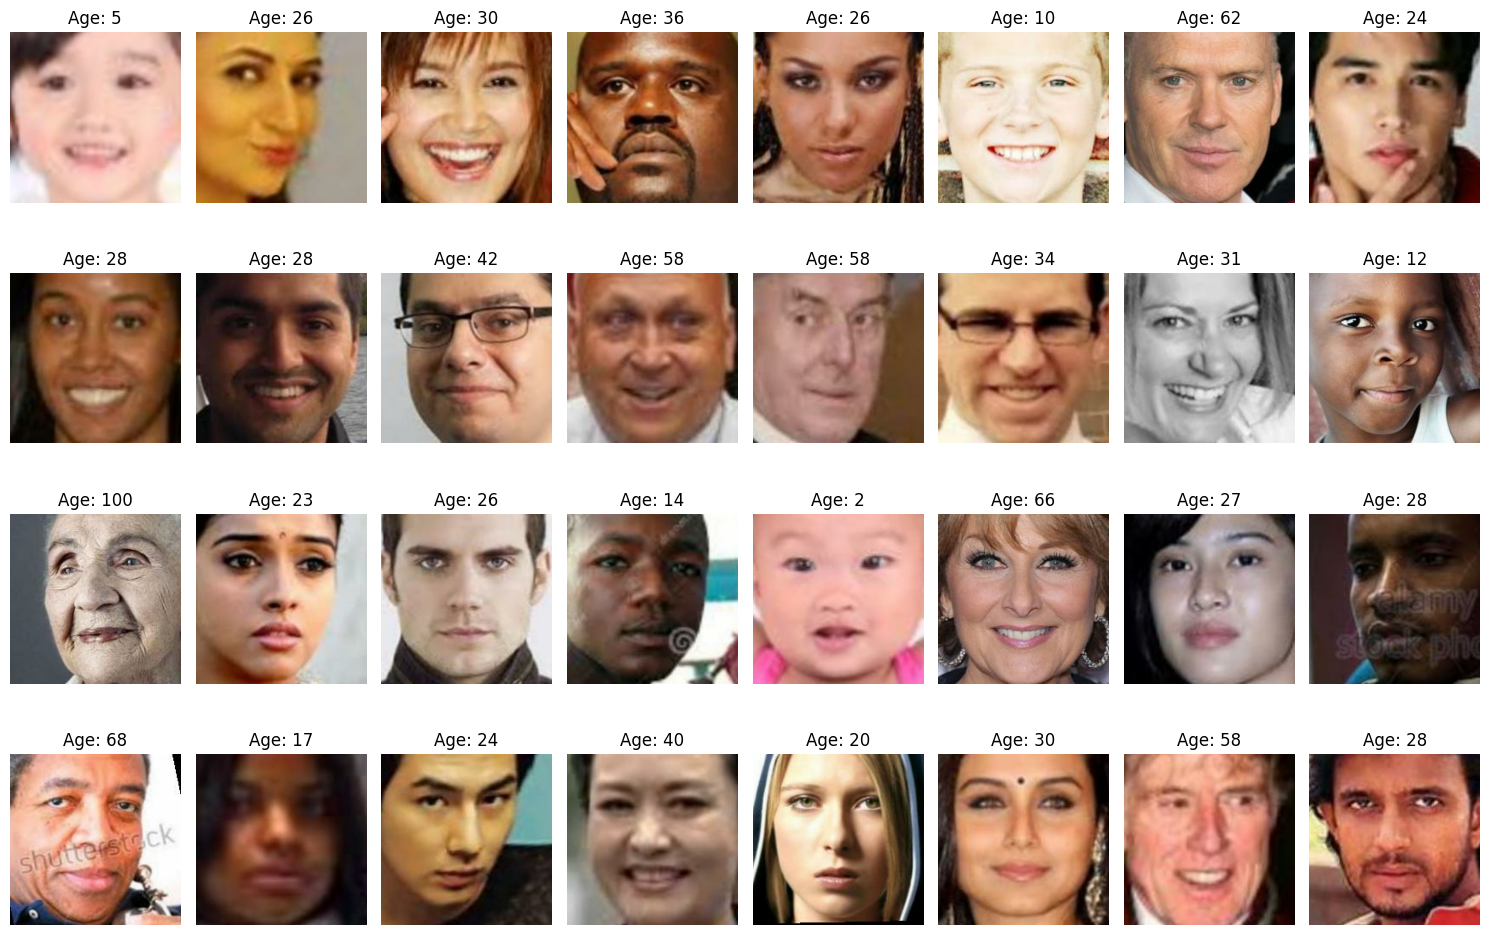

In [8]:
# 이미지가 저장된 경로 (앞서 정의한 경로)
dir_path = "UTKFace/"

# 전체 이미지 플롯의 크기 설정 (가로 15인치, 세로 10인치)
plt.figure(figsize=(15, 10))

# train_ds에서 한 배치(BATCH_SIZE만큼)를 가져옴
for images, ages in train_ds.batch(BATCH_SIZE).take(1):

    # 해당 배치의 이미지 개수만큼 반복
    for index in range(len(images)):
        # 이미지 경로를 사용해 이미지 파일 로딩 및 디코딩
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)

        # 4행 8열 서브플롯에 이미지 시각화
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)

        # 이미지 상단에 나이와 성별 정보 표시
        plt.title(f"Age: {ages[index]}")

        # 축은 표시하지 않음
        plt.axis("off")

# 레이아웃 자동 정렬 (타이틀 겹침 방지)
plt.tight_layout()

# 플롯 출력
plt.show()

In [13]:
# 다양한 사전 학습된 이미지 분류 백본 모델 초기화
# 각 모델은 ImageNet 데이터셋으로 사전 학습되었으며, 최상위 분류 층은 제거된 상태 (include_top=False)

backbones = [
    (
        "ResNet50V2",  # ResNet의 개선된 버전, 성능과 효율성 균형
        ResNet50V2(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "ResNet152V2",  # 더 깊은 ResNet, 더 많은 파라미터와 높은 표현력
        ResNet152V2(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

]

  2424832/234545216 [..............................] - ETA: 41s

KeyboardInterrupt: 

# 전이 학습 모델 선택
* VGG 이도현  
* ResNet 백지웅
* Alexnet 전형진
* Xception 배성범
* custom1 CNN 김태우
* custom2 CNN 이현석

In [ ]:
import os

def cls():
    os.system('cls' if os.name == 'nt' else 'clear')

나이 예측 모델 학습 결과 요약

1. MobileNet 계열 백본

- 성능이 일관되게 나빠서 이번 과제에 적합하지 않음.

- 명확히 제외 대상임.

2. VGG16 백본

- 가장 유망한 모델.

- 훈련 손실과 검증 손실이 꾸준히 감소하며 안정적으로 수렴함.

- 평균 절대 오차(MAE)가 약 8.0 근처에서 안정됨.

- 모델이 튼튼하고 일반화 성능이 좋음.

3. Inception, Xception 백본

- 훈련 손실은 낮지만, 훈련과 검증 손실 간 차이가 큼(과적합 가능성 있음).

- Inception은 Xception보다 학습 곡선이 더 부드럽고 예측 가능함.

- 속도와 안정성 면에서 Inception이 좋은 대안임.

# 주어진 모델 훈련 파트


In [41]:
# loss 함수
class AgeLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=1.0, beta=0.0, gamma=0.0):
        super(AgeLoss, self).__init__()
        self.alpha = alpha  # cross-entropy 가중치
        self.beta = beta    # mean loss 가중치
        self.gamma = gamma  # variance loss 가중치
    
    def call(self, y_true, y_pred):
        """
        :param y_true: [batch_size,] (1-100)
        :param y_pred: [batch_size, 100] (logits)
        """
        # Cross-Entropy Loss (분류)
        y_true_idx = tf.cast(y_true, tf.int32) - 1 # 0~99 인덱스
        ce_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(y_true_idx, y_pred)
        
        # Softmax 확률
        softmax_y_pred = tf.nn.softmax(y_pred, axis=-1)
        ages = tf.range(1, 101, dtype="float32")
        
        # Mean Loss (회귀)
        mean_y_pred = tf.reduce_sum(softmax_y_pred * ages, axis=1)
        mean_loss = tf.reduce_mean(tf.square(tf.cast(y_true, tf.float32) - mean_y_pred))
        
        # Variance Loss (분포 집중)
        variance_y_pred = tf.reduce_sum(
            softmax_y_pred * tf.square(ages - tf.expand_dims(mean_y_pred, -1)), axis=1
        )
        variance_loss = tf.reduce_mean(variance_y_pred)
        
        # 최종 손실
        total_loss = (
            self.alpha * ce_loss +
            self.beta * mean_loss +
            self.gamma * variance_loss
        )
        return total_loss

# MAE
def mae_metric(y_true, y_pred):
    # y_pred: [batch, 100] softmax 확률분포 → 기대값(예측 나이)으로 변환
    softmax_y_pred = tf.nn.softmax(y_pred, axis=-1)
    ages = tf.range(1, 101, dtype=tf.float32)
    mean_y_pred = tf.reduce_sum(softmax_y_pred * ages, axis=1)
    return tf.reduce_mean(tf.abs(tf.cast(y_true, tf.float32) - mean_y_pred))

In [42]:
# resnet50 백본 모델 불러오기 (최상위 분류층 제외, ImageNet 가중치 사용)
resnet50v2 = ResNet50V2(
                input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
                weights = "imagenet",
                include_top = False
            )
# 백본 모델 가중치 고정 (학습 중 변경하지 않음)
resnet50v2.trainable = True
for layer in resnet50v2.layers[:-10]:
    layer.trainable = False
# resnet50v2.trainable = False

inputs = Input((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput")
x = Lambda(lambda x: tf.keras.applications.resnet_v2.preprocess_input(x))(inputs)
x = resnet50v2(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
outputs = Dense(100)(x)

age_net = Model(inputs = inputs, outputs = outputs)

# # 나이 예측 네트워크 생성 (Sequential 모델 사용)
# age_net = Sequential([
#     # 입력층: 이미지 크기 지정
#     InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
#     
#     Lambda(lambda x: tf.keras.applications.resnet_v2.preprocess_input(x)),
#     
#     # VGG16 백본 연결 (특징 추출 역할)
#     resnet50v2,
# 
#     # 출력 피처를 1차원 벡터로 변환
#     GlobalAveragePooling2D(),  # 출력 shape: (None, 2048)
# 
#     # 드롭아웃: 40% 비율로 뉴런 무작위 비활성화하여 과적합 방지
#     Dropout(0.5, name="SlightDroput1"),
# 
#     # 완전 연결층: 256개 뉴런, ReLU 활성화 함수, He 초기화 사용
#     Dense(256, activation="relu"),
#     
#     BatchNormalization(),
#     
#     Dropout(0.3, name="SlightDroput2"),
# 
#     # 출력층: 100개 뉴런, 나이 예측 (회귀 문제)
#     Dense(100, name="AgeOutput")
# ], name="AgeNet")

# 모델 컴파일: 손실 함수는 MAE, 최적화는 Adam
age_net.compile(
    loss=AgeLoss(),       # (mean loss + softmax loss)
    optimizer=Adam(learning_rate=0.0001),     # Adam 옵티마이저
    metrics=[mae_metric],   # mae metric
    weighted_metrics=[]   # 별도의 가중치 메트릭 없음
)

In [16]:
age_net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ImageInput (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                             

In [43]:
# 나이 예측 모델 학습 시작
age_history = age_net.fit(
    train_age_ds,                 # 학습용 데이터셋
    validation_data=valid_age_ds, # 검증용 데이터셋
    epochs=50,                   # 최대 20 에폭까지 학습
    batch_size=BATCH_SIZE,        # 배치 크기 (사용자 지정 상수)
    callbacks=[                   # 학습 도중 호출되는 콜백 함수 목록
        EarlyStopping(
            patience=5,               # 검증 손실이 5번 연속 개선되지 않으면 학습 중단
            monitor="val_loss",       # 검증 손실(val_loss)을 모니터링
            restore_best_weights=True # 최적의 가중치로 복원
        ),
        ModelCheckpoint(
            "Age-ResNet-v1.keras",    # 최적 모델 저장 파일명
            save_best_only=True    # 가장 성능 좋은 모델만 저장
        ),
        TensorBoard(
            log_dir='logs'
        )
    ]
)

Epoch 1/50
601/601 [==============================] - 60s 93ms/step - loss: 4.8434 - mae_metric: 21.3697 - val_loss: 4.0731 - val_mae_metric: 21.0476
Epoch 2/50
601/601 [==============================] - 54s 91ms/step - loss: 4.2906 - mae_metric: 19.9794 - val_loss: 3.8320 - val_mae_metric: 19.5914
Epoch 3/50
601/601 [==============================] - 55s 91ms/step - loss: 3.9704 - mae_metric: 19.2637 - val_loss: 3.6849 - val_mae_metric: 18.2072
Epoch 4/50
601/601 [==============================] - 55s 91ms/step - loss: 3.8002 - mae_metric: 18.8717 - val_loss: 3.5833 - val_mae_metric: 17.7411
Epoch 5/50
601/601 [==============================] - 55s 91ms/step - loss: 3.6964 - mae_metric: 18.8301 - val_loss: 3.6160 - val_mae_metric: 19.2390
Epoch 6/50
601/601 [==============================] - 56s 92ms/step - loss: 3.6135 - mae_metric: 18.8896 - val_loss: 3.4671 - val_mae_metric: 19.1437
Epoch 7/50
601/601 [==============================] - 55s 91ms/step - loss: 3.5469 - mae_metric: 19.

KeyboardInterrupt: 

In [11]:
# age_model1 = tf.keras.models.load_model("model/Age-ResNet-v0.keras")
age_net.load_weights("model/Age-ResNet-v0.keras")


In [31]:
ds = train_age_ds.take(10)
print(ds)

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


1/1 [==============================] - 0s 21ms/step


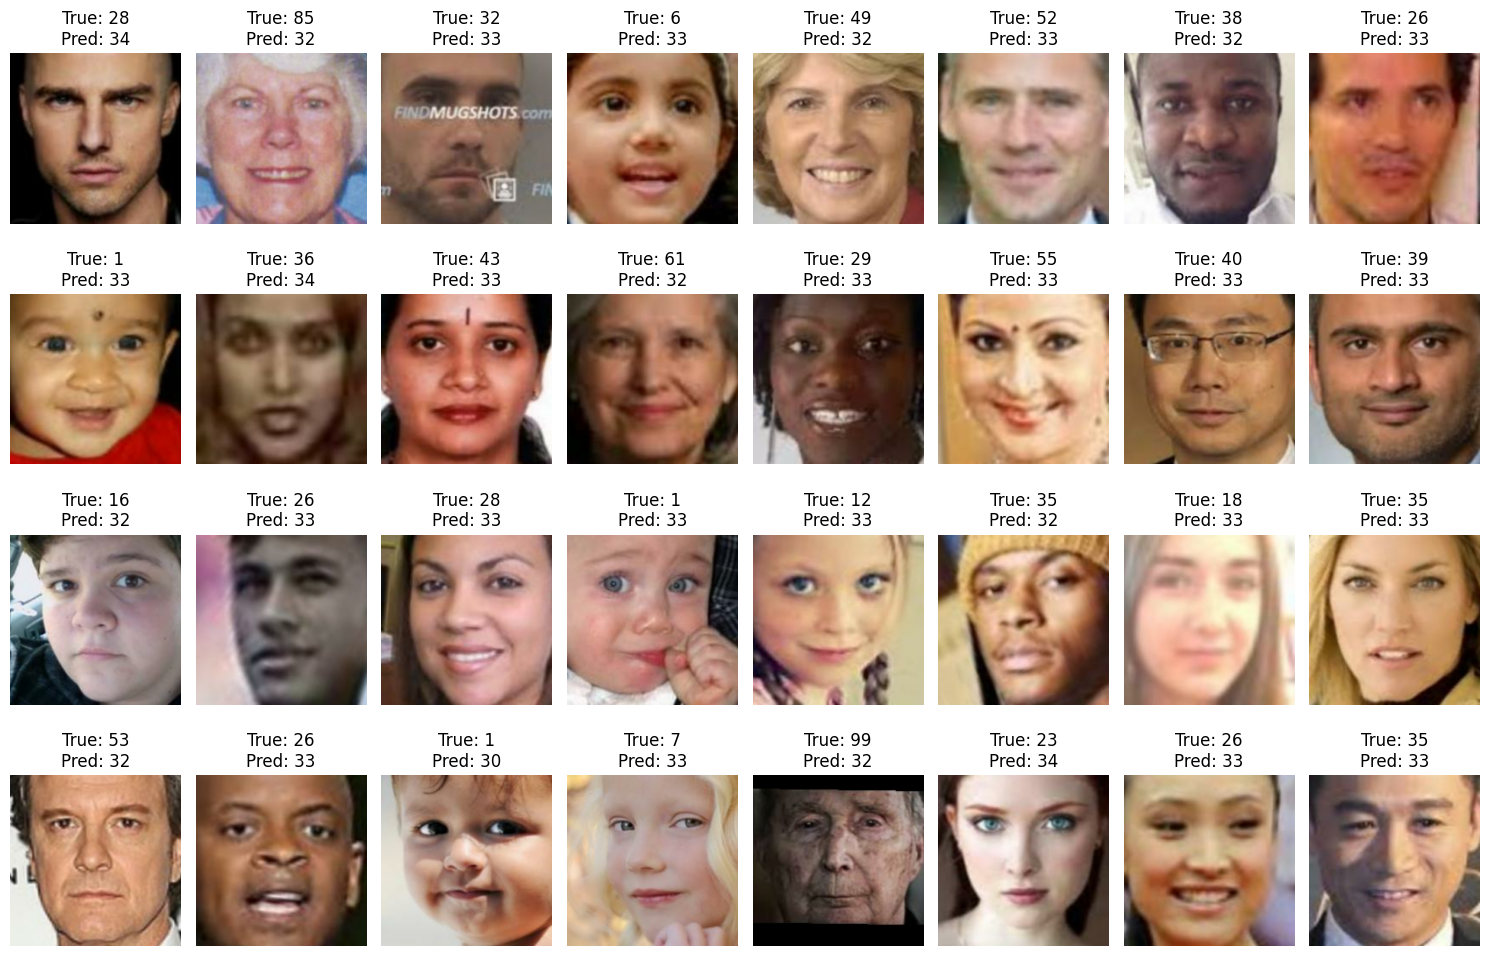

In [40]:
# 이미지가 저장된 경로 (앞서 정의한 경로)
dir_path = "UTKFace/"

# 배치 하나만 가져오기
for ds in train_age_ds.take(1):
    # 모델 예측
    images, y_true = ds
    y_pred = age_net.predict(images)
    softmax_y_pred = tf.nn.softmax(y_pred, axis=-1)
    pred_age = tf.math.argmax(softmax_y_pred, axis=-1)
    plt.figure(figsize=(15, 10))
    for index in range(len(images)):
        plt.subplot(4, 8, index + 1)
        # 이미지 텐서를 numpy로 변환 후 시각화
        plt.imshow(images[index])
        plt.title(f"True: {y_true[index].numpy()}\nPred: {pred_age[index].numpy()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


In [ ]:
test = train_age_ds.batch(BATCH_SIZE).take(10)
test_pred = age_net.predict(test)

In [24]:
softmax_y = tf.nn.softmax(y_pred)
softmax_y[1,:]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([1.34153715e-05, 3.91667845e-06, 5.91170692e-06, 4.96939083e-06,
       8.08523237e-06, 5.14507337e-06, 6.82235805e-06, 1.86646066e-05,
       2.26717038e-05, 2.21958217e-05, 1.21388075e-05, 3.54169715e-05,
       2.21241789e-05, 3.77949145e-05, 5.56292471e-05, 8.38396008e-05,
       7.10725653e-05, 1.53006506e-04, 7.36299771e-05, 1.61518008e-04,
       1.49621264e-04, 3.16399819e-04, 3.44326516e-04, 7.16932525e-04,
       8.33952334e-04, 2.39812071e-03, 1.77482620e-03, 4.88763070e-03,
       7.25818425e-03, 1.98716894e-02, 9.82972444e-04, 1.04732521e-01,
       3.74975055e-01, 3.53927016e-01, 4.78355400e-02, 2.98853833e-02,
       1.24833109e-02, 6.00717496e-03, 6.11524004e-03, 9.69022419e-03,
       1.42042350e-03, 1.91418629e-03, 8.39645450e-04, 4.11563466e-04,
       2.11261655e-03, 4.95512097e-04, 6.47891022e-04, 5.49616525e-04,
       3.08450719e-04, 9.26241279e-04, 3.17024154e-04, 5.29650715e-04,
       4.07769141e-04, 8.0323